# Investigating Neural Network Architectures: Overview of Experiments

In this section, we systematically explore various aspects of neural network architectures and hyperparameters to understand their impact on model performance. The goal is to identify optimal configurations that improve training efficiency and generalization. Below are the experiments we will perform:

### 1. **Effect of Layers and Neurons**
   - Investigate how the number of layers and the number of neurons per layer influence training and validation loss.
   - Generate 3D visualizations to analyze the interaction between these architectural components.

### 2. **Optimal Depth and Width**
   - Examine the impact of strictly decreasing layer sizes (e.g., 1024 → 512 → 256) to find optimal depth-width configurations.
   - Highlight validation loss for different layer structures using structured tables.

### 3. **Dropout Rate and Activation Function**
   - Study the interaction between dropout rates and activation functions (`ReLU`, `Tanh`).
   - Visualize validation loss trends across different dropout rates for each activation function.

### 4. **Optimizer Convergence**
   - Compare the performance of popular optimizers (`Adam`, `SGD`, `RMSprop`) in terms of convergence behavior over training epochs.
   - Analyze both training and validation loss trends to determine the most effective optimizer for the task.

### 5. **Batch Size and Learning Rate**
   - Explore the relationship between batch size and learning rate to identify optimal combinations.
   - Use a heatmap to analyze validation loss and fit a curve to describe the dependency of learning rate on batch size.

Each experiment is designed to isolate key variables and provide insights into best practices for building and training neural networks. The results will be visualized using intuitive plots, and all findings will be documented for future reference.


In [ ]:
from utils.common_imports import *
from utils.data_utils import *
from utils.model_utils import *
from utils.experiments_utils import *
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

set_reproducibility()

# Use the custom style
plt.style.use('latex_style.mplstyle')

# Create directory for saving results
results_dir = "experiment_results"
os.makedirs(results_dir, exist_ok=True)

/Users/shahabnasiri/Library/Mobile Documents/com~apple~CloudDocs/All/CAMBRIDGE/M1/m1_ml_for_dis/sy475/mnist_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Prepare datasets
train_dataset, val_dataset, test_dataset = prepare_datasets()

### Experiment: Effect of Layers and Neurons on Loss

#### **Experiment Execution**
- **Objective**: Analyze the impact of varying the number of layers and neurons per layer on training and validation loss.
- **Procedure**:
  - Iterate over a range of layer counts (`num_layers_range`) and neuron counts (`neurons_per_layer_range`).
  - For each combination:
    - Configure a neural network with the specified number of layers and neurons.
    - Train the model and record the training and validation loss at the end of the training process.
  - Save the results as a CSV file for later analysis.

#### **Results Visualization**
- **Objective**: Plot the training and validation loss for each combination of layers and neurons.
- **Procedure**:
  - Load the results from the saved CSV file.
  - Create a 3D surface plot:
    - **X-axis**: Neurons per layer.
    - **Y-axis**: Number of layers.
    - **Z-axis**: Loss (training and validation shown as separate surfaces).
  - Add colorbars to indicate the magnitude of training and validation loss.

#### **Key Outputs**
- **CSV File**: Contains the recorded training and validation loss for each combination.
- **3D Surface Plot**: Visual representation of the impact of layers and neurons on loss.
- **PDF Export**: Save the plot for sharing or reporting.


In [ ]:
def layers_neurons_experiment(
    default_config, train_dataset, val_dataset, test_dataset, 
    num_layers_range=[1, 2, 3, 4, 5], neurons_per_layer_range=[64, 128, 256, 512, 1024]
):
    """
    Experiment 1: Effect of layers and neurons on training and validation loss.
    """
    results = []
    for num_layers in num_layers_range:
        for neurons in neurons_per_layer_range:
            config = default_config.copy()
            config["hidden_sizes"] = [neurons] * num_layers
            train_loader, val_loader, _ = create_data_loaders(train_dataset, val_dataset, test_dataset, config["batch_size"])
            model, criterion, optimizer, scheduler = initialize_nn_and_training_components(config, input_size=1568, output_size=19)
            history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, config["epochs"])
            results.append({"num_layers": num_layers, "neurons_per_layer": neurons, "val_loss": history["val_loss"][-1], "train_loss": history["train_loss"][-1]})
    save_results_to_csv(results, "experiment_1", results_dir)
def plot_layers_neurons_experiment_results():
    """
    Plot results for Experiment 1: Layers and Neurons.
    """

    results_df = pd.read_csv("experiment_results/experiment_1_results.csv")
    num_layers = results_df["num_layers"].unique()
    neurons_per_layer = results_df["neurons_per_layer"].unique()

    X, Y = np.meshgrid(neurons_per_layer, num_layers)
    Z_train = np.zeros_like(X, dtype=np.float32)
    Z_val = np.zeros_like(X, dtype=np.float32)

    for i, layers in enumerate(num_layers):
        for j, neurons in enumerate(neurons_per_layer):
            train_loss = results_df[
                (results_df["num_layers"] == layers) & (results_df["neurons_per_layer"] == neurons)
            ]["train_loss"]
            val_loss = results_df[
                (results_df["num_layers"] == layers) & (results_df["neurons_per_layer"] == neurons)
            ]["val_loss"]
            Z_train[i, j] = train_loss.values[0] if not train_loss.empty else np.nan
            Z_val[i, j] = val_loss.values[0] if not val_loss.empty else np.nan

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection="3d")
    surf_train = ax.plot_surface(X, Y, Z_train, cmap="Blues", alpha=0.8, edgecolor="k")
    surf_val = ax.plot_surface(X, Y, Z_val, cmap="Oranges", alpha=0.8, edgecolor="k")

    # Adjust the axis labels
    ax.set_xlabel("Neurons per Layer")
    ax.set_ylabel("Number of Layers")
    ax.set_zlabel("Loss")
    ax.set_title("Training and Validation Loss by Layers and Neurons")

    # Create a colorbar axis for training loss
    cbar_ax_train = fig.add_axes([0.78, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
    cbar_train = plt.colorbar(surf_train, cax=cbar_ax_train)
    cbar_train.set_label("Training Loss")

    # Create a colorbar axis for validation loss
    cbar_ax_val = fig.add_axes([0.85, 0.25, 0.02, 0.5])  # Adjust left and width to move closer
    cbar_val = plt.colorbar(surf_val, cax=cbar_ax_val)
    cbar_val.set_label("Validation Loss")

    # Save the figure
    plt.savefig("experiment_1_layers_neurons_results.pdf", format="pdf")

    # Show the plot
    plt.show()


### Experiment: Optimal Depth and Width (Strictly Decreasing Layer Sizes)

#### **Experiment Execution**
- **Objective**: Explore the impact of strictly decreasing layer sizes on training and validation loss.
- **Procedure**:
  - Generate all possible configurations of layers with strictly decreasing neuron counts, starting from a predefined sequence (`neuron_sequence`).
  - For each configuration:
    - Set the `hidden_sizes` for the model.
    - Train the model and record training and validation loss.
  - Save the results to a CSV file for detailed analysis.

#### **Results Visualization**
- **Objective**: Analyze the performance of various layer configurations and identify optimal structures.
- **Procedure**:
  - Load the saved results from the CSV file.
  - Sort and group the results by the number of layers (`num_layers`).
  - Create a table displaying:
    - Layer configurations (`hidden_sizes`) for each number of layers.
    - Corresponding validation loss.
  - Use color gradients to highlight the best-performing configurations for each group.

#### **Key Outputs**
- **CSV File**: Contains the recorded training and validation loss for each layer configuration.
- **Styled Table**: Interactive display of layer structures and their validation loss.
  - Highlighted gradients help identify optimal configurations.


In [4]:
def optimal_depth_width_experiment(
    default_config, train_dataset, val_dataset, test_dataset, 
    neuron_sequence=[1024, 512, 256, 128, 64]
):
    """
    Experiment 2: Strictly decreasing layer sizes.
    """
    results = []
    for num_layers in range(2, len(neuron_sequence) + 1):
        for layer_config in combinations(neuron_sequence, num_layers):
            config = default_config.copy()
            config["hidden_sizes"] = list(layer_config)
            train_loader, val_loader, _ = create_data_loaders(train_dataset, val_dataset, test_dataset, config["batch_size"])
            model, criterion, optimizer, scheduler = initialize_nn_and_training_components(config, input_size=1568, output_size=19)
            history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, config["epochs"])
            results.append({"num_layers": num_layers, "hidden_sizes": config["hidden_sizes"], "val_loss": history["val_loss"][-1], "train_loss": history["train_loss"][-1]})
    save_results_to_csv(results, "experiment_2", results_dir)


def plot_optimal_depth_width_experiment_results():
    """
    Plot results for Experiment 2: Decreasing Layer Sizes.
    """
    results_df = pd.read_csv("experiment_results/experiment_2_results.csv")
    sorted_results = results_df.sort_values(by=["num_layers", "val_loss"])
    grouped = sorted_results.groupby("num_layers")
    tables = []

    for num_layers, group in grouped:
        display_table = group[["hidden_sizes", "val_loss"]].sort_values(by="val_loss").reset_index(drop=True)
        display_table.columns = pd.MultiIndex.from_tuples(
            [(f"{num_layers} Layers", "Hidden Sizes"), (f"{num_layers} Layers", "Validation Loss")]
        )
        tables.append(display_table)

    concatenated_table = pd.concat(tables, axis=1)
    styled_table = concatenated_table.style.set_caption("Validation Loss by Layer Structures") \
                                           .format(precision=4, na_rep="").background_gradient(cmap="viridis", axis=0)
    display(styled_table)


### Experiment: Effect of Dropout Rates and Activation Functions

#### **Experiment Execution**
- **Objective**: Investigate how varying dropout rates and activation functions impact training and validation loss.
- **Procedure**:
  - Iterate over a range of dropout rates and activation functions.
  - For each combination:
    - Update the model configuration with the specified dropout rate and activation function.
    - Train the model and record the training and validation loss.
  - Save the results to a CSV file for detailed analysis.

#### **Results Visualization**
- **Objective**: Analyze and compare the effect of dropout rates and activation functions on model performance.
- **Procedure**:
  - Load the saved results from the CSV file.
  - Create a line plot:
    - **X-axis**: Dropout rates.
    - **Y-axis**: Validation loss.
    - **Legend**: Different activation functions.
  - Overlay the performance of each activation function across the dropout rates.

#### **Key Outputs**
- **CSV File**: Contains the recorded training and validation loss for each dropout rate and activation function combination.
- **Line Plot**: Visualization showing the relationship between dropout rates, activation functions, and validation loss.
- **PDF Export**: Save the plot for sharing or reporting.


In [5]:
def dropout_activation_experiment(
    default_config, train_dataset, val_dataset, test_dataset, 
    dropout_rates=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], 
    activation_functions=["ReLU", "Tanh"]
):
    """
    Experiment 3: Effect of dropout rates and activation functions on training and validation loss.
    """
    results = []
    for activation_function in activation_functions:
        for dropout_rate in dropout_rates:
            config = default_config.copy()
            config["dropout_rate"] = dropout_rate
            config["activation_function"] = activation_function
            train_loader, val_loader, _ = create_data_loaders(train_dataset, val_dataset, test_dataset, config["batch_size"])
            model, criterion, optimizer, scheduler = initialize_nn_and_training_components(config, input_size=1568, output_size=19)
            history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, config["epochs"])
            results.append({"activation_function": activation_function, "dropout_rate": dropout_rate, "val_loss": history["val_loss"][-1], "train_loss": history["train_loss"][-1]})
    save_results_to_csv(results, "experiment_3", results_dir)


def plot_dropout_activation_experiment_results():
    """
    Plot results for Experiment 3: Dropout and Activation Interaction.
    """
    results_df = pd.read_csv("experiment_results/experiment_3_results.csv")
    plt.figure(figsize=(12, 6))

    for activation_function, group in results_df.groupby("activation_function"):
        plt.plot(group["dropout_rate"], group["val_loss"], marker="o", label=f"{activation_function}")

    plt.xlabel("Dropout Rate")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss by Dropout Rate and Activation Function")
    plt.legend()
    plt.grid()
    plt.savefig("experiment_3_dropout_activation_results.pdf", format="pdf")

    plt.show()


### Experiment: Optimizer Convergence Comparison

#### **Experiment Execution**
- **Objective**: Compare the convergence behavior of different optimizers over training epochs.
- **Procedure**:
  - Iterate over a list of optimizers (`Adam`, `SGD`, `RMSprop`).
  - For each optimizer:
    - Configure the model with the specified optimizer.
    - Train the model while recording training and validation loss at each epoch.
    - Repeat the experiment for a specified number of trials (`n_trials`) to account for variability.
  - Save the epoch-wise results for each optimizer to a CSV file for analysis.

#### **Results Visualization**
- **Objective**: Visualize and analyze the convergence of training and validation loss for different optimizers.
- **Procedure**:
  - Load the results from the saved CSV file.
  - Create line plots for each optimizer:
    - **Solid Line**: Training loss over epochs.
    - **Dashed Line**: Validation loss over epochs.
    - **Dotted Line**: Mark the last epoch (convergence point) for each optimizer.
  - Use distinct colors to represent different optimizers for clear comparison.

#### **Key Outputs**
- **CSV File**: Contains the training and validation loss for each optimizer across all epochs and trials.
- **Line Plot**: Visual comparison of convergence behavior for different optimizers, highlighting training and validation loss trends.
- **PDF Export**: Save the plot for reporting or future reference.


In [6]:
def optimiser_convergence_experiment(
    default_config, train_dataset, val_dataset, test_dataset, 
    optimizers=["Adam", "SGD", "RMSprop"], n_trials=1
):
    """
    Experiment 4: Compare training and validation loss over epochs for different optimizers.
    """
    results = []
    for optimizer_name in optimizers:
        for trial in range(n_trials):
            config = default_config.copy()
            config["optimizer"] = optimizer_name
            train_loader, val_loader, _ = create_data_loaders(train_dataset, val_dataset, test_dataset, config["batch_size"])
            model, criterion, optimizer, scheduler = initialize_nn_and_training_components(config, input_size=1568, output_size=19)
            history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, config["epochs"])
            for epoch, (train_loss, val_loss) in enumerate(zip(history["train_loss"], history["val_loss"])):
                results.append({"optimizer": optimizer_name, "epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})
    save_results_to_csv(results, "experiment_4", results_dir)
    
def plot_optimiser_convergence_experiment_results():
    """
    Plot results for Experiment 4: Optimizer Comparison with convergence points.
    """
    results_df = pd.read_csv("experiment_results/experiment_4_results.csv")
    plt.figure(figsize=(12, 6))
    colors = plt.cm.tab10.colors
    optimizer_colors = {optimizer: colors[i] for i, optimizer in enumerate(results_df["optimizer"].unique())}

    for optimizer in results_df["optimizer"].unique():
        optimizer_data = results_df[results_df["optimizer"] == optimizer]
        plt.plot(
            optimizer_data["epoch"],
            optimizer_data["train_loss"],
            label=f"{optimizer} - Train Loss",
            color=optimizer_colors[optimizer],
        )
        plt.plot(
            optimizer_data["epoch"],
            optimizer_data["val_loss"],
            label=f"{optimizer} - Val Loss",
            color=optimizer_colors[optimizer],
            linestyle="--",
        )

        # Add a vertical line at the last epoch for this optimizer
        last_epoch = optimizer_data["epoch"].max()
        plt.axvline(
            x=last_epoch,
            color=optimizer_colors[optimizer],
            linestyle=":",
            linewidth=1.5,
            label=f"{optimizer} Converged (Epoch {last_epoch})"
        )

    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Optimiser Convergence Comparison", fontsize=16)
    plt.legend(fontsize=10, loc="upper right")
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.savefig("experiment_4_optimiser_convergence_experiment.pdf", format="pdf")

    plt.show()


### Experiment: Batch Size and Learning Rate Interaction

#### **Experiment Execution**
- **Objective**: Analyze how batch size and learning rate interact to influence training and validation loss.
- **Procedure**:
  1. Iterate over a grid of batch sizes and learning rates.
  2. For each combination:
     - Configure the model with the specified batch size and learning rate.
     - Train the model and record the training and validation loss at the final epoch.
  3. Save the results in a structured format (CSV) for detailed analysis.

#### **Results Visualization**
The analysis is divided into three parts:

1. **Heatmap: Validation Loss Across Batch Sizes and Learning Rates**
   - **Objective**: Visualize how validation loss varies for different combinations of batch sizes and learning rates.
   - **Procedure**:
     - Construct a heatmap from the results.
     - Highlight the minimum validation loss for each batch size with a red box.
   - **Output**: A heatmap showing validation loss across batch sizes and learning rates.

2. **Linear Fit: Optimal Learning Rate per Batch Size**
   - **Objective**: Investigate the relationship between batch size and the optimal learning rate.
   - **Procedure**:
     - Identify the learning rate that minimizes validation loss for each batch size.
     - Fit a linear model to the relationship between batch size and optimal learning rate.
   - **Output**:
     - A scatter plot of the optimal learning rates.
     - A linear fit overlaid to provide insights into the trend.

3. **Validation Loss vs Learning Rate / Batch Size Ratio**
   - **Objective**: Explore the impact of the ratio of learning rate to batch size (LR/BS) on validation loss.
   - **Procedure**:
     - Compute the LR/BS ratio for each configuration.
     - Plot validation loss against the LR/BS ratio on a logarithmic scale.
   - **Output**: A scatter plot showing the relationship between validation loss and LR/BS ratio.

#### **Key Outputs**
- **CSV File**: Contains the final validation and training loss for each configuration.
- **Visualizations**:
  - Heatmap with highlighted minimum validation loss.
  - Scatter plot with a linear fit for batch size vs. optimal learning rate.
  - Log-scale scatter plot of validation loss vs. LR/BS ratio.
- **PDF Exports**: Each visualization is saved as a high-quality PDF for further documentation or reporting.


In [ ]:
def batch_size_lr_experiment(
    default_config, train_dataset, val_dataset, test_dataset, 
    batch_sizes=[16, 32, 64, 128, 256, 512], learning_rates=np.linspace(0.0001, 0.001, num=6)
):
    """
    Experiment 5: Effect of batch size and learning rate on training and validation loss.
    """
    results = []
    for batch_size in batch_sizes:
        for lr in learning_rates:
            config = default_config.copy()
            config["batch_size"] = batch_size
            config["lr"] = lr
            train_loader, val_loader, _ = create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size)
            model, criterion, optimizer, scheduler = initialize_nn_and_training_components(config, input_size=1568, output_size=19)
            history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, config["epochs"])
            results.append({"batch_size": batch_size, "learning_rate": lr, "val_loss": history["val_loss"][-1], "train_loss": history["train_loss"][-1]})
    save_results_to_csv(results, "experiment_5", results_dir)

def plot_batch_size_lr_experiment_results():
    """
    Plot results for Experiment 5: Batch Size and Learning Rate Analysis with outlier removal.
    Includes:
    1. Heatmap highlighting minimum validation loss.
    2. Linear fit for optimal Learning Rate vs Batch Size.
    3. Validation Loss vs. LR/BS ratio plot (log scale).
    """

    # Load the data
    results_df = pd.read_csv("experiment_results/experiment_5_results.csv")
    results_df["learning_rate"] = results_df["learning_rate"].round(5)

    # Define outlier removal criteria (IQR method)
    q1 = results_df["val_loss"].quantile(0.25)
    q3 = results_df["val_loss"].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filter out outliers
    filtered_df = results_df[(results_df["val_loss"] >= lower_bound) & (results_df["val_loss"] <= upper_bound)]

    # 1. Plot Heatmap of Validation Loss
    pivot_table = filtered_df.pivot(index="batch_size", columns="learning_rate", values="val_loss")
    min_vals_mask = (pivot_table == pivot_table.min(axis=1, skipna=True).values[:, None])

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(
        pivot_table,
        cmap="viridis",
        annot=True,
        fmt=".2f",
        cbar_kws={"label": "Validation Loss"},
        linewidths=0.5
    )

    # Highlight cells with the lowest loss in each row
    for i, row in enumerate(pivot_table.index):
        for j, col in enumerate(pivot_table.columns):
            if min_vals_mask.iloc[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

    plt.xticks(rotation=0)
    plt.xlabel("Learning Rate")
    plt.ylabel("Batch Size")
    plt.title("Validation Loss: Batch Size vs Learning Rate")
    plt.tight_layout()
    plt.savefig("experiment_5_heatmap_combined.pdf", format="pdf")
    plt.show()

    # 2. Fit Linear Model to Best Learning Rates
    best_lr_per_batch = filtered_df.loc[filtered_df.groupby("batch_size")["val_loss"].idxmin()]
    best_lr_per_batch = best_lr_per_batch[["batch_size", "learning_rate", "val_loss"]]

    x = best_lr_per_batch["batch_size"].values.reshape(-1, 1)
    y = best_lr_per_batch["learning_rate"].values

    linear_model = LinearRegression()
    linear_model.fit(x, y)
    slope = linear_model.coef_[0]
    intercept = linear_model.intercept_

    # Plot Linear Fit
    plt.figure(figsize=(12, 6))
    x_vals = np.linspace(best_lr_per_batch["batch_size"].min(), best_lr_per_batch["batch_size"].max(), 100)
    plt.plot(best_lr_per_batch["batch_size"], best_lr_per_batch["learning_rate"], 'o', label="Best Learning Rates")
    plt.plot(x_vals, slope * x_vals + intercept, '-', label=rf"Fitted Curve: $y = {slope:.4f}x + {intercept:.4f}$")
    plt.xlabel("Batch Size")
    plt.ylabel("Learning Rate")
    plt.title("Optimal Learning Rate vs. Batch Size (Linear Fit)")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig("experiment_5_linear_fit_combined.pdf", format="pdf")
    plt.show()

    # 3. Plot Validation Loss vs LR/BS Ratio
    filtered_df["lr_bs_ratio"] = filtered_df["learning_rate"] / filtered_df["batch_size"]

    plt.figure(figsize=(12, 6))
    plt.scatter(filtered_df["lr_bs_ratio"], filtered_df["val_loss"], c="blue", alpha=0.7, label="Data Points")
    plt.xscale('log')
    plt.xlabel("Learning Rate / Batch Size Ratio (Log Scale)")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss vs LR/BS Ratio")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig("experiment_5_lr_bs_ratio_combined.pdf", format="pdf")
    plt.show()

    # Print Best Learning Rates
    print("Best Learning Rate per Batch Size (Filtered):")
    print(best_lr_per_batch)


In [ ]:
# Default configuration
default_config = {
    "hidden_sizes": [512, 256],  # Layers configuration
    "activation_function": "ReLU",  # Activation function
    "dropout_rate": 0.1,  # Dropout rate
    "lr": 0.005,  # Learning rate
    "batch_size": 64,  # Batch size
    "epochs": 10,  # Number of epochs
    "optimizer": "Adam"  # Optimizer
}

# Run Layers and Neurons Experiment
print("Running Layers and Neurons Experiment")
num_layers_range = [1, 2, 3, 4,5,6,7,8]  # Example customization
neurons_per_layer_range = [64, 128, 256, 512,1024]  # Example customization
layers_neurons_experiment(
    default_config, train_dataset, val_dataset, test_dataset, 
    num_layers_range=num_layers_range, neurons_per_layer_range=neurons_per_layer_range
)
print("Visualizing Results for Layers and Neurons Experiment")
plot_layers_neurons_experiment_results()


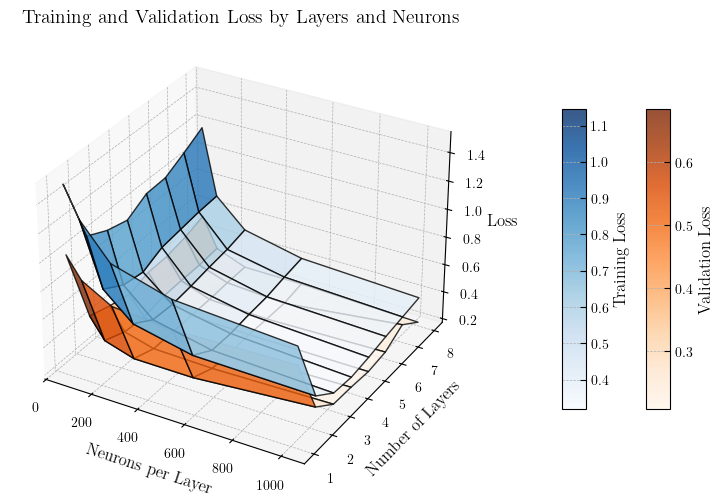

In [38]:
plot_layers_neurons_experiment_results()

In [15]:
# Default configuration
default_config = {
    "hidden_sizes": [512, 256],  # Layers configuration
    "activation_function": "ReLU",  # Activation function
    "dropout_rate": 0.1,  # Dropout rate
    "lr": 0.005,  # Learning rate
    "batch_size": 64,  # Batch size
    "epochs": 10,  # Number of epochs
    "optimizer": "Adam"  # Optimizer
}

# Run Optimal Depth and Width Experiment
print("\nRunning Optimal Depth and Width Experiment")
neuron_sequence = [1024, 512, 256, 128,64]  # Example customization
optimal_depth_width_experiment(
    default_config, train_dataset, val_dataset, test_dataset, 
    neuron_sequence=neuron_sequence
)
print("Visualizing Results for Optimal Depth and Width Experiment")
plot_optimal_depth_width_experiment_results()



Running Optimal Depth and Width Experiment
Epoch 1/10, Train Loss: 1.6410, Val Loss: 0.8370, Train Acc: 48.49%, Val Acc: 84.05%
Epoch 2/10, Train Loss: 0.9981, Val Loss: 0.4263, Train Acc: 68.86%, Val Acc: 87.79%
Epoch 3/10, Train Loss: 0.7902, Val Loss: 0.3313, Train Acc: 75.49%, Val Acc: 89.95%
Epoch 4/10, Train Loss: 0.6776, Val Loss: 0.7371, Train Acc: 79.02%, Val Acc: 90.88%
Epoch 5/10, Train Loss: 0.5968, Val Loss: 1.1456, Train Acc: 81.32%, Val Acc: 91.92%
Early stopping triggered.
Epoch 1/10, Train Loss: 1.6057, Val Loss: 0.6003, Train Acc: 49.11%, Val Acc: 83.29%
Epoch 2/10, Train Loss: 0.9848, Val Loss: 0.4068, Train Acc: 69.50%, Val Acc: 88.20%
Epoch 3/10, Train Loss: 0.7925, Val Loss: 0.3743, Train Acc: 75.46%, Val Acc: 89.72%
Epoch 4/10, Train Loss: 0.6742, Val Loss: 0.3077, Train Acc: 79.14%, Val Acc: 91.65%
Epoch 5/10, Train Loss: 0.5972, Val Loss: 0.2944, Train Acc: 81.37%, Val Acc: 91.47%
Epoch 6/10, Train Loss: 0.5333, Val Loss: 0.3310, Train Acc: 83.27%, Val Acc: 91


Running Dropout and Activation Experiment
Using 7 workers for DataLoader.
Epoch 1/20, Train Loss: 1.5435, Val Loss: 0.5475, Train Acc: 51.05%, Val Acc: 84.00%
Epoch 2/20, Train Loss: 0.9161, Val Loss: 0.4510, Train Acc: 71.75%, Val Acc: 87.28%
Epoch 3/20, Train Loss: 0.7213, Val Loss: 0.3686, Train Acc: 77.67%, Val Acc: 88.96%
Epoch 4/20, Train Loss: 0.6055, Val Loss: 0.3286, Train Acc: 81.17%, Val Acc: 90.86%
Epoch 5/20, Train Loss: 0.5274, Val Loss: 0.3347, Train Acc: 83.47%, Val Acc: 91.21%
Epoch 6/20, Train Loss: 0.4678, Val Loss: 0.3762, Train Acc: 85.30%, Val Acc: 91.38%
Epoch 7/20, Train Loss: 0.4142, Val Loss: 0.3230, Train Acc: 86.75%, Val Acc: 91.30%
Epoch 8/20, Train Loss: 0.3744, Val Loss: 0.2987, Train Acc: 88.00%, Val Acc: 91.62%
Epoch 9/20, Train Loss: 0.3422, Val Loss: 0.2835, Train Acc: 88.94%, Val Acc: 92.11%
Epoch 10/20, Train Loss: 0.3136, Val Loss: 0.2878, Train Acc: 89.78%, Val Acc: 92.36%
Epoch 11/20, Train Loss: 0.2897, Val Loss: 0.2806, Train Acc: 90.46%, Val 

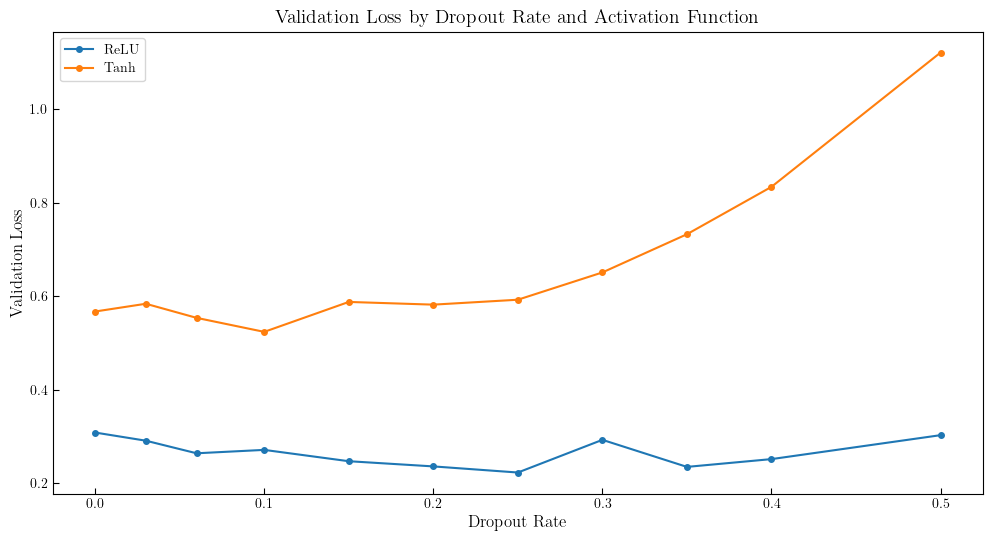

In [10]:
# Default configuration
default_config = {
    "hidden_sizes": [512, 256],  # Layers configuration
    "activation_function": "ReLU",  # Activation function
    "dropout_rate": 0.1,  # Dropout rate
    "lr": 0.005,  # Learning rate
    "batch_size": 64,  # Batch size
    "epochs": 20,  # Number of epochs
    "optimizer": "Adam"  # Optimizer
}

# Run Dropout and Activation Experiment
print("\nRunning Dropout and Activation Experiment")
dropout_rates = [0.0, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3,0.35,0.4,0.5]

activation_functions = ["ReLU", "Tanh"]  # Example customization
dropout_activation_experiment(
    default_config, train_dataset, val_dataset, test_dataset, 
    dropout_rates=dropout_rates, activation_functions=activation_functions
)
print("Visualizing Results for Dropout and Activation Experiment")
plot_dropout_activation_experiment_results()



Running Optimizer Convergence Experiment
Using 7 workers for DataLoader.
Epoch 1/30, Train Loss: 1.6473, Val Loss: 0.5674, Train Acc: 47.57%, Val Acc: 83.25%
Epoch 2/30, Train Loss: 1.0366, Val Loss: 0.4234, Train Acc: 68.09%, Val Acc: 87.76%
Epoch 3/30, Train Loss: 0.8333, Val Loss: 0.3491, Train Acc: 74.28%, Val Acc: 89.40%
Epoch 4/30, Train Loss: 0.7243, Val Loss: 0.3099, Train Acc: 77.65%, Val Acc: 90.97%
Epoch 5/30, Train Loss: 0.6512, Val Loss: 0.2934, Train Acc: 79.84%, Val Acc: 91.20%
Epoch 6/30, Train Loss: 0.5942, Val Loss: 0.2899, Train Acc: 81.44%, Val Acc: 91.41%
Epoch 7/30, Train Loss: 0.5464, Val Loss: 0.3261, Train Acc: 82.88%, Val Acc: 91.58%
Epoch 8/30, Train Loss: 0.5061, Val Loss: 0.2688, Train Acc: 84.02%, Val Acc: 92.28%
Epoch 9/30, Train Loss: 0.4789, Val Loss: 0.2765, Train Acc: 84.83%, Val Acc: 92.72%
Epoch 10/30, Train Loss: 0.4482, Val Loss: 0.2997, Train Acc: 85.78%, Val Acc: 92.50%
Early stopping triggered.
Using 7 workers for DataLoader.
Epoch 1/30, Train

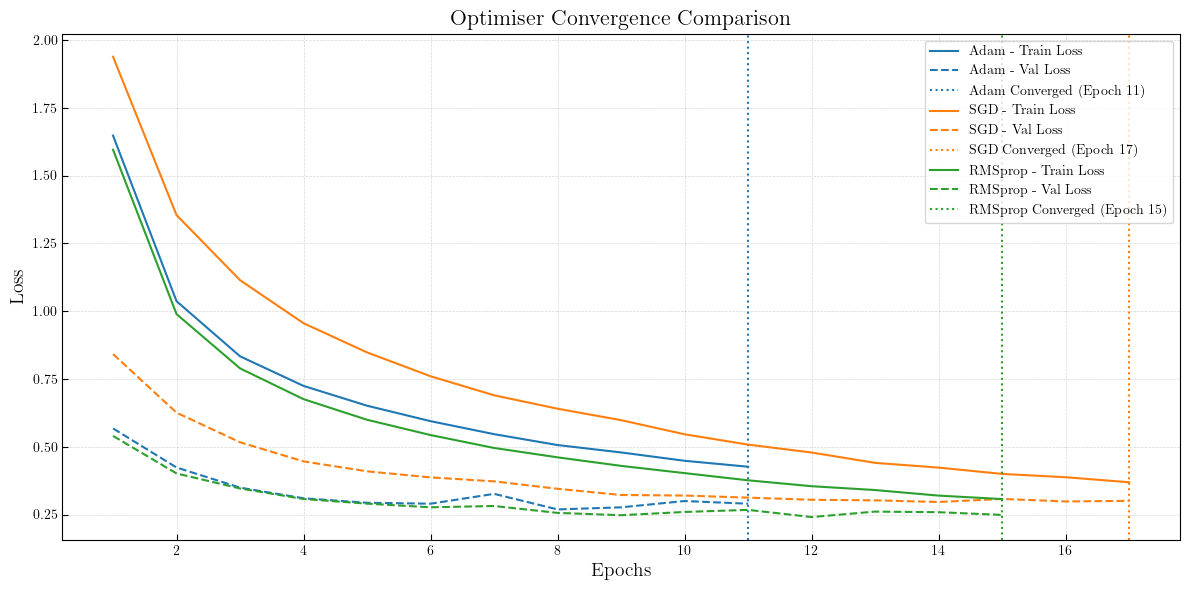

In [16]:
# Default configuration
default_config = {
    "hidden_sizes": [512, 256],  # Layers configuration
    "activation_function": "ReLU",  # Activation function
    "dropout_rate": 0.1,  # Dropout rate
    "lr": 0.005,  # Learning rate
    "batch_size": 64,  # Batch size
    "epochs": 30,  # Number of epochs
    "optimizer": "Adam"  # Optimizer
}

# Run Optimizer Convergence Experiment
print("\nRunning Optimizer Convergence Experiment")
optimizers = ["Adam", "SGD", "RMSprop"]
optimiser_convergence_experiment(
    default_config, train_dataset, val_dataset, test_dataset, 
    optimizers=optimizers
)
print("Visualizing Results for Optimizer Convergence Experiment")
plot_optimiser_convergence_experiment_results()


In [ ]:
default_config = {
    "hidden_sizes": [512, 256],  # Layers configuration
    "activation_function": "ReLU",  # Activation function
    "dropout_rate": 0.1,  # Dropout rate
    "lr": 0.005,  # Learning rate (may need adjustment)
    "batch_size": 64,  # Batch size
    "epochs": 15,  # Number of epochs
    "optimizer": "SGD"
}


# Run Batch Size and Learning Rate Experiment
print("\nRunning Batch Size and Learning Rate Experiment")
# batch_sizes = np.logspace(np.log2(16), np.log2(512), num=10, base=2).astype(int)
# Output: [16, 22, 32, 45, 64, 91, 128, 181, 256, 362, 512]
batch_sizes = [16,  23,  34,  50,  74, 109, 161, 237, 348, 512]
learning_rates = np.logspace(-4, 0, num=13)


batch_size_lr_experiment(
    default_config, train_dataset, val_dataset, test_dataset, 
    batch_sizes=batch_sizes, learning_rates=learning_rates
)
print("Visualizing Results for Batch Size and Learning Rate Experiment")
plot_batch_size_lr_experiment_results()



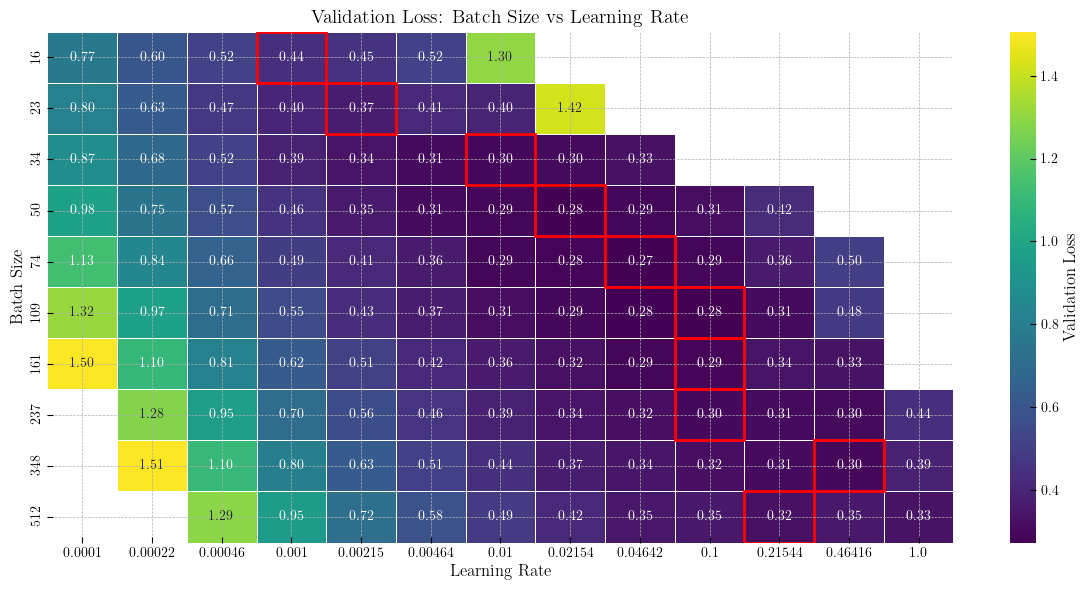

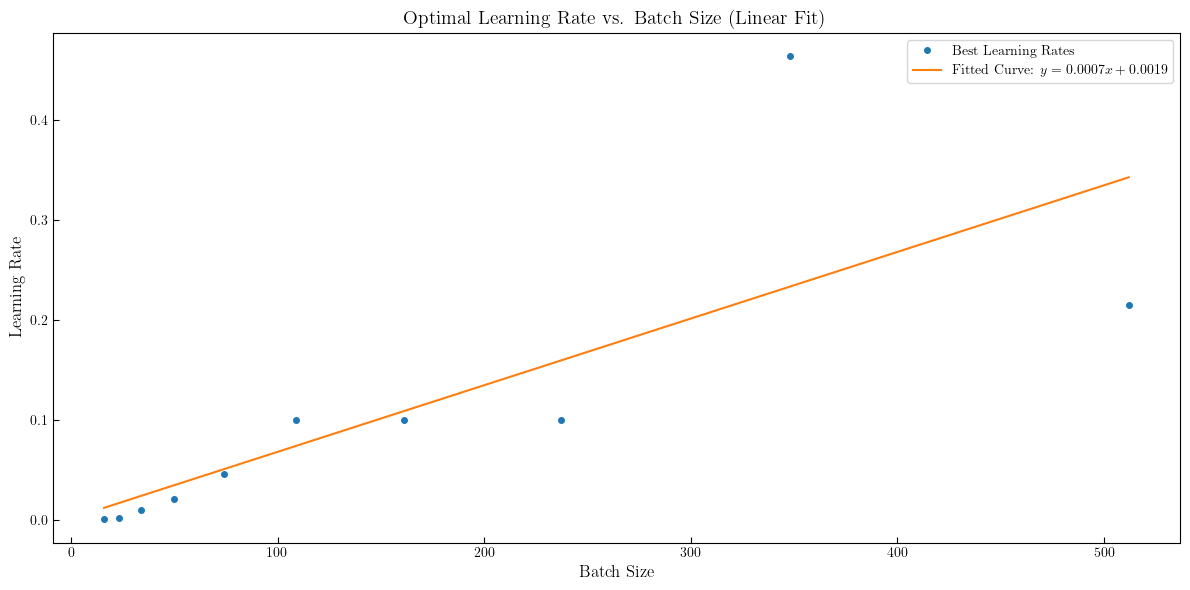

/var/folders/nj/gjz0sd9j2gsg4k3t40yvpsvr0000gn/T/ipykernel_72603/2799887201.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["lr_bs_ratio"] = filtered_df["learning_rate"] / filtered_df["batch_size"]


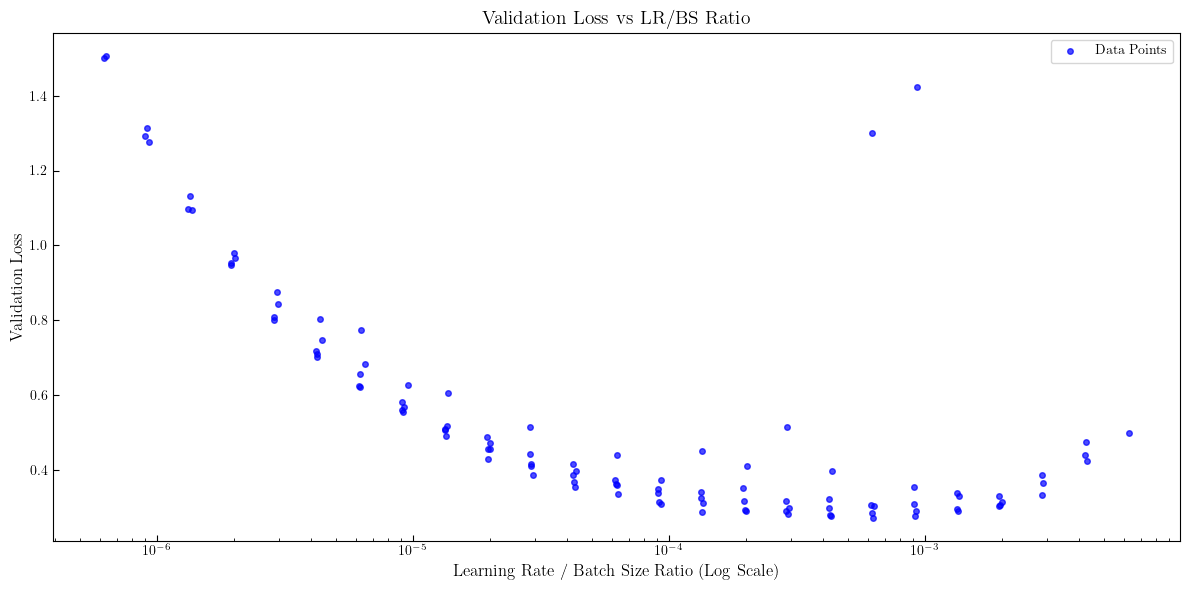

Best Learning Rate per Batch Size (Filtered):
     batch_size  learning_rate  val_loss
3            16        0.00100  0.440854
17           23        0.00215  0.373505
32           34        0.01000  0.299435
46           50        0.02154  0.276559
60           74        0.04642  0.272778
74          109        0.10000  0.276091
87          161        0.10000  0.286105
100         237        0.10000  0.298035
115         348        0.46416  0.295009
127         512        0.21544  0.321867


In [9]:
plot_batch_size_lr_experiment_results()